In [1]:
from tensorflow.keras import layers, Model
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
import glob
from tqdm import tqdm

In [2]:
class AutoEncoder3DOld: # Works but it uses 2d convolutional layers >:(
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling2D((2, 2), padding="same")(x)
        x = layers.Dropout(0.1)(x)
        encoded = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        encoded = layers.MaxPooling2D((2, 2), padding="same")(encoded)

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(64, 64, 8))  # Shape of encoded latent space
        x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(170, (3, 3), activation="relu", padding="same")(x)

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder (combine encoder and decoder)
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(encoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()

        return

    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

In [ ]:
class AutoEncoder3D:
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv3D(4, (3, 3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Downscale
        #x = layers.Dropout(0.1)(x)
        #x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        #x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Further downscale
        
        #x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        #x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Further downscale

        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)  # Latent space
        encoded = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Final downscale for compact latent space

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(64, 64, 44, 8))  # Adjust latent space shape (smaller)
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(decoder_input)
        #x = layers.UpSampling3D((2, 2, 2))(x)  # Upscale
        #x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        
        #x = layers.UpSampling3D((2, 2, 2))(x)  # Upscale
        #x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)

        x = layers.UpSampling3D((2, 2, 2))(x)  # Upscale
        x = layers.Conv3D(4, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling3D((2, 2, 2))(x)  # Final upscale to original shape
        decoded = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)  # Sigmoid for [0, 1] range output

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder (combine encoder and decoder)
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(encoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        # Compile the autoencoder
        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()

    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

In [2]:
class AutoEncoder3D:
    def __init__(self, input_shape=(256, 256, 176, 1)):
        self.input_shape = input_shape
        self.autoencoder = self.build_autoencoder()

    def build_autoencoder(self):
        # Encoder
        encoder_input = layers.Input(shape=self.input_shape)
        x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(encoder_input)
        x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
        x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
        x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
        encoded = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)

        # Decoder
        x = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(encoded)
        x = layers.UpSampling3D((2, 2, 2))(x)
        x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling3D((2, 2, 2))(x)
        x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling3D((2, 2, 2))(x)
        decoded = layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

        # Autoencoder model
        autoencoder = Model(encoder_input, decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        return autoencoder

    def train(self, x_train, x_val, epochs=50, batch_size=4):
        """
        Train the autoencoder.

        :param x_train: Training data, expected shape (n, 256, 256, 176, 1).
        :param x_val: Validation data, expected shape (n, 256, 256, 176, 1).
        :param epochs: Number of training epochs.
        :param batch_size: Batch size for training.
        """
        return self.autoencoder.fit(
            x_train, x_train,
            validation_data=(x_val, x_val),
            epochs=epochs,
            batch_size=batch_size
        )

    def encode(self, x):
        """
        Encode the input data to its latent representation.

        :param x: Input data, expected shape (n, 256, 256, 176, 1).
        :return: Latent representation of the input data.
        """
        encoder = Model(
            self.autoencoder.input, 
            self.autoencoder.layers[-7].output  # Output of the encoder layer
        )
        return encoder.predict(x)

    def decode(self, encoded):
        """
        Decode the latent representation back to the original input shape.

        :param encoded: Latent representation, shape inferred from encoder output.
        :return: Reconstructed data with shape (n, 256, 256, 176, 1).
        """
        # Extract the decoder part
        encoded_input = layers.Input(shape=encoded.shape[1:])
        decoder_layers = self.autoencoder.layers[-7:]

        x = encoded_input
        for layer in decoder_layers:
            x = layer(x)

        decoder = Model(encoded_input, x)
        return decoder.predict(encoded)


In [3]:
scan_paths = glob.glob("C:/Users/PieHu/Documents/GitHub/DementiaMRI/Data/Pre-processed/Scaled and padded/**/*.nii", recursive=True)
scans = []

for path in tqdm(scan_paths[:10], desc="Loading scans"):
    path = path.replace("\\","/")
    scans.append(nib.load(path).get_fdata()*0.001)
scans = np.array(scans)
scans.shape

Loading scans: 100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


(10, 256, 256, 176)

In [4]:
input_shape = list(scans.shape[1:])
input_shape.append(1)
autoencoder = AutoEncoder3D()#AutoEncoder3DOld((256,256,170)) # input_shape

In [ ]:
history = autoencoder.train(scans[:4]*0.001,scans[4:5]*0.001, epochs=50, batch_size=8)
# history = autoencoder.train(scans[:8,:,:,:170]*0.001, epochs=100, batch_size=8)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node functional_1/up_sampling3d_2_1/Repeat/Tile defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2288.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 640, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2288.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1992, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2288.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\kernelbase.py", line 531, in process_one

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\kernelbase.py", line 775, in execute_request

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\PieHu\AppData\Local\Temp\ipykernel_25964\486193631.py", line 1, in <module>

  File "C:\Users\PieHu\AppData\Local\Temp\ipykernel_25964\3902464524.py", line 40, in train

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py", line 175, in call

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py", line 560, in call

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\reshaping\up_sampling3d.py", line 99, in call

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\reshaping\up_sampling3d.py", line 129, in _resize_volumes

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\ops\numpy.py", line 4406, in repeat

  File "C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\numpy.py", line 1775, in repeat

OOM when allocating tensor with shape[8,128,2,128,88,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node functional_1/up_sampling3d_2_1/Repeat/Tile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_3713]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


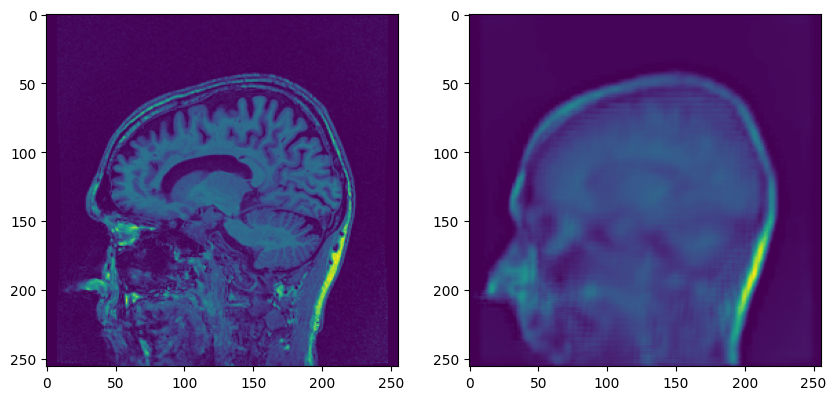

In [117]:
test_idx = 2
latent = autoencoder.encoder.predict(scans[test_idx:test_idx+1,:,:,:170])
recon = autoencoder.decoder.predict(latent)

fix, ax = plt.subplots(1,2,figsize=(10,30))
ax[0].imshow(scans[test_idx][:,:,80])
ax[1].imshow(recon[0,:,:,80])
#ax[2].imshow(scans[test_idx][:,:,80]-recon[0].reshape(256,256,172)[:,:,80])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


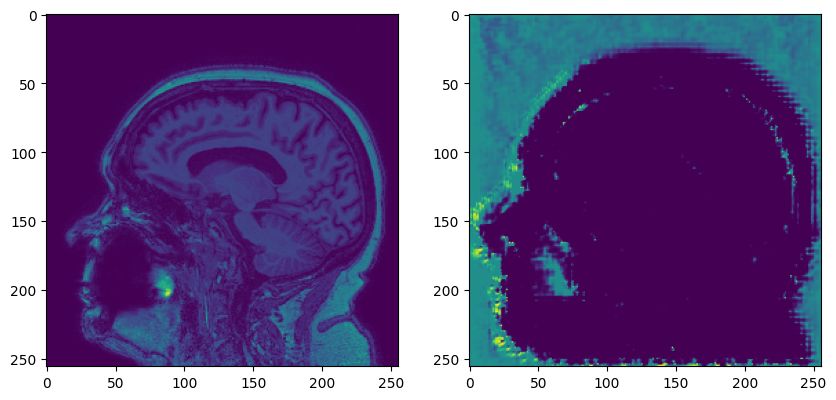

In [50]:
test_idx = 20
latent = autoencoder.encoder.predict(scans[test_idx:test_idx+1])
recon = autoencoder.decoder.predict(latent)

fix, ax = plt.subplots(1,2,figsize=(10,30))
ax[0].imshow(scans[test_idx][:,:,80])
ax[1].imshow(recon[0,:,:,80])
#ax[2].imshow(scans[test_idx][:,:,80]-recon[0].reshape(256,256,172)[:,:,80])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


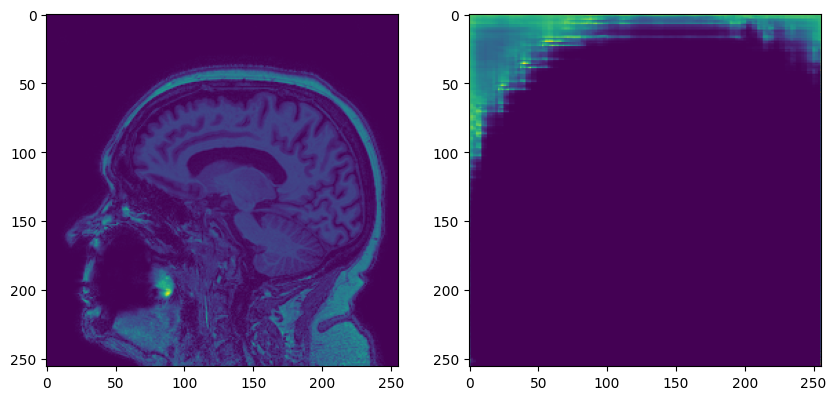

In [40]:
test_idx = 20
latent = autoencoder.encoder.predict(scans[test_idx:test_idx+1])
recon = autoencoder.decoder.predict(latent)

fix, ax = plt.subplots(1,2,figsize=(10,30))
ax[0].imshow(scans[test_idx][:,:,80])
ax[1].imshow(recon[0,:,:,80])
#ax[2].imshow(scans[test_idx][:,:,80]-recon[0].reshape(256,256,172)[:,:,80])